In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import spiceypy as sp
from ATATools import ata_ephem
from ATATools import ata_control as ac

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
sp.furnsh('spice/naif0012.tls')
sp.furnsh('spice/de432s.bsp')
sp.furnsh('spice/pck00011.tpc')
sp.furnsh('spice/hera_sc_crema_2_1_LPO_241007_261202_v01.bsp')
sp.furnsh('spice/ata.bsp')
sp.furnsh('spice/ata.tf')
sp.furnsh('spice/earth_latest_high_prec.bpc')
sp.boddef('ATA', 399999)

In [3]:
begin = np.datetime64('2024-10-07T16:10:00')
end = np.datetime64('2024-10-07T18:00:00')
#end = np.datetime64('2024-10-07T21:20:00')
t_step = (0.1 * 1e9) * np.timedelta64(1, 'ns')
t_axis = begin + np.arange((end - begin) / t_step + 1) * t_step

In [4]:
j2000_unix = (np.datetime64('2000-01-01T12:00') - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
time_shift = np.timedelta64(round(20*60), 's')  # 17 minutes work at 16:25 CEST
time_shift = 0
pos = np.empty((t_axis.size, 3))
t_tai = np.empty(t_axis.size)
for j, utc in enumerate(t_axis):
    et = sp.utc2et(str(utc - time_shift))
    pos[j] = sp.spkpos('-91', et, 'ATA_TOPO', 'LT+S', 'ATA')[0]
    et = sp.utc2et(str(utc))
    t_tai[j] = sp.unitim(et, 'ET', 'TAI') + j2000_unix

sp.unload('spice/hera_sc_crema_2_1_LPO_241007_261202_v01.bsp')
sp.furnsh('spice/hera_fcp_000021_241007_261118_v01.bsp')
pos_new = np.empty((t_axis.size, 3))
for j, utc in enumerate(t_axis):
    et = sp.utc2et(str(utc - time_shift))
    pos_new[j] = sp.spkpos('-91', et, 'ATA_TOPO', 'LT+S', 'ATA')[0]

In [5]:
dist = np.sqrt(np.sum(pos**2, axis=1))
elev = np.rad2deg(np.arcsin(pos[:, 2] / dist))
azim = np.rad2deg(np.angle(pos[:, 0] - 1j * pos[:, 1])) % 360

dist_new = np.sqrt(np.sum(pos_new**2, axis=1))
elev_new = np.rad2deg(np.arcsin(pos_new[:, 2] / dist_new))
azim_new = np.rad2deg(np.angle(pos_new[:, 0] - 1j * pos_new[:, 1])) % 360

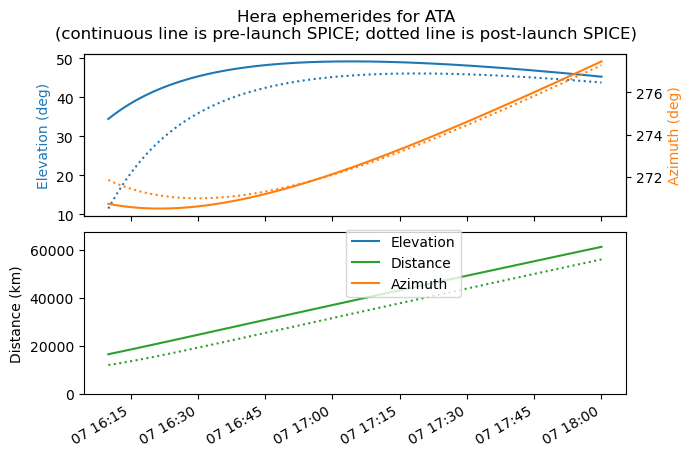

In [6]:
fig, axs = plt.subplots(2, figsize=(7, 5), sharex=True)
axs[0].plot(t_axis, elev, label='Elevation')
axs[0].plot(t_axis, elev_new, ':', color='C0')
axs[0].set_ylabel('Elevation (deg)', color='C0')
#axs[0].set_ylim(0, 90)
ax2 = axs[0].twinx()
ax2.set_ylabel('Azimuth (deg)', color='C1')
ax2.plot(t_axis, azim, color='C1', label='Azimuth')
ax2.plot(t_axis, azim_new, ':', color='C1')
#ax2.set_ylim(0, 360)
axs[1].plot(t_axis, dist, color='C2', label='Distance')
axs[1].plot(t_axis, dist_new, ':', color='C2')
axs[1].set_ylabel('Distance (km)')
axs[1].set_ylim(0, np.max(dist) * 1.1)
fig.autofmt_xdate()
plt.subplots_adjust(hspace=0.1)
fig.legend(loc=[0.5, 0.35])
plt.suptitle('Hera ephemerides for ATA\n(continuous line is pre-launch SPICE; dotted line is post-launch SPICE)',
             y=0.97);

In [7]:
ir = t_axis.size * [1e-10]
ephem = np.array([t_tai * 1e9, azim, elev, ir], dtype='object').T
ephem_path = '/tmp/hera.eph'
ata_ephem.ephem_to_txt('/tmp/hera.eph', ephem)

In [8]:
#eph_id = ac.upload_ephemeris(ephem_path)
#antennas = ['1a']
#ac.track_ephemeris(eph_id, antennas)